In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

In [ ]:
# Load the datasets
train_path = '/content/drive/My Drive/Titanic/train.csv'
test_path = '/content/drive/My Drive/Titanic/test.csv'

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
# Inspect the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Step 1: Data Preprocessing
# Create separate imputers for Age and Fare
age_imputer = SimpleImputer(strategy='median')
fare_imputer = SimpleImputer(strategy='median')

In [ ]:
# Impute missing Age values in train and test datasets
train_df['Age'] = age_imputer.fit_transform(train_df[['Age']])
test_df['Age'] = age_imputer.transform(test_df[['Age']])

In [ ]:
# Impute missing Fare values in the test dataset
test_df['Fare'] = fare_imputer.fit_transform(test_df[['Fare']])

In [ ]:
# Drop irrelevant columns: PassengerId, Name, Ticket, and Cabin
train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
# Fit and transform the 'Sex' and 'Embarked' columns
X_train_encoded = encoder.fit_transform(train_df[['Sex', 'Embarked']])
X_test_encoded = encoder.transform(test_df[['Sex', 'Embarked']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Convert encoded features to DataFrame
encoded_train_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))
encoded_test_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))

In [ ]:
# Drop original categorical columns and concatenate the new encoded columns
train_df = train_df.drop(columns=['Sex', 'Embarked']).reset_index(drop=True)
test_df = test_df.drop(columns=['Sex', 'Embarked']).reset_index(drop=True)

train_df = pd.concat([train_df, encoded_train_df], axis=1)
test_df = pd.concat([test_df, encoded_test_df], axis=1)

In [ ]:
# Step 3: Define features and target variable
X = train_df.drop(columns='Survived')
y = train_df['Survived']

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 4: Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Step 5: Predict and Evaluate the model
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)}")

Training Accuracy: 0.9789325842696629
Validation Accuracy: 0.8156424581005587


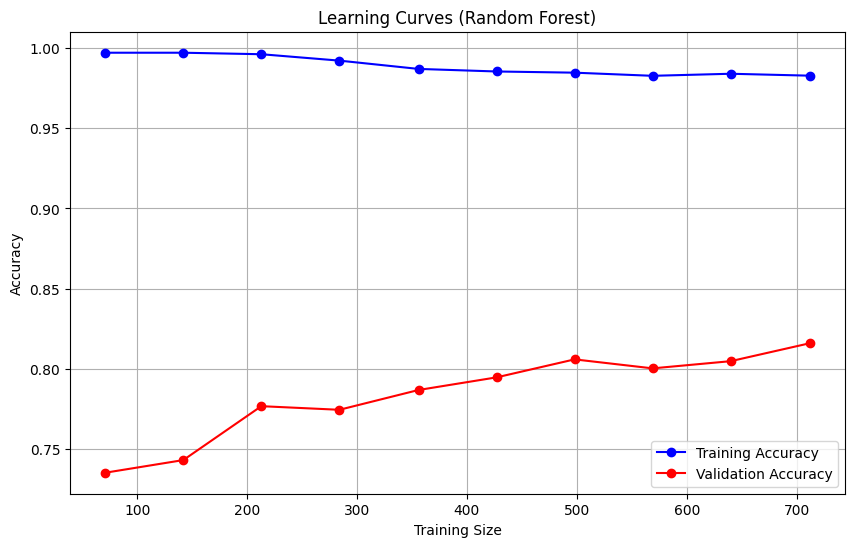

In [ ]:
# Step 6: Plot Learning Curves (Training and Validation Errors)
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Accuracy')
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

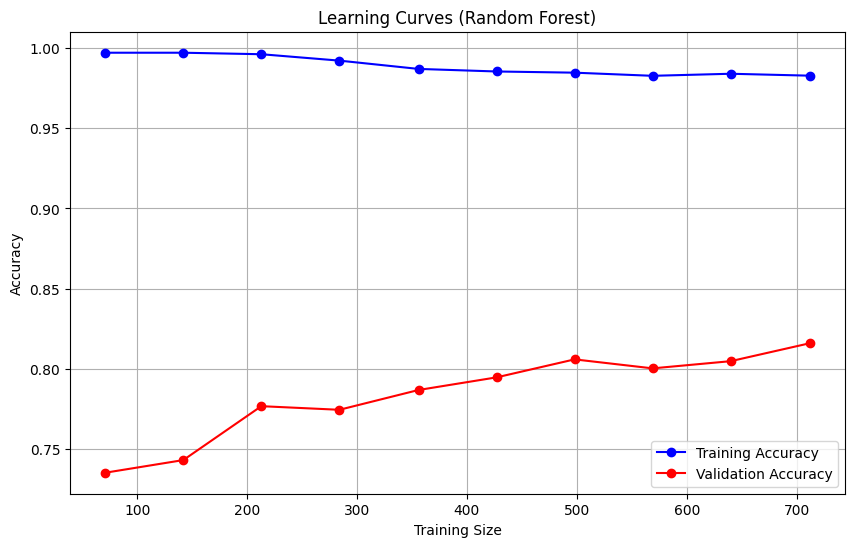

The model shows good generalization performance.


In [ ]:
# Step 7: Analyze the learning curve and make recommendations
def analyze_learning_curve(train_scores_mean, val_scores_mean, train_sizes):
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Accuracy')
    plt.title('Learning Curves (Random Forest)')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    if val_scores_mean[-1] < 0.8:
        print("The model may be underfitting. Consider increasing model complexity or tuning hyperparameters.")
    elif train_scores_mean[-1] > 0.95 and val_scores_mean[-1] < 0.8:
        print("The model is overfitting. Consider using regularization, reducing model complexity, or employing techniques like cross-validation.")
    else:
        print("The model shows good generalization performance.")

analyze_learning_curve(train_scores_mean, val_scores_mean, train_sizes)

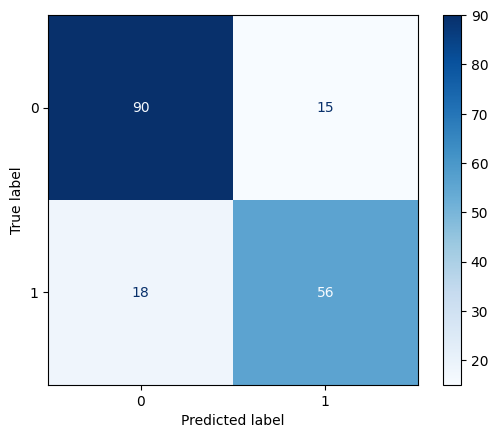

In [ ]:
# Optional: Plot confusion matrix to analyze misclassifications
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_val = clf.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

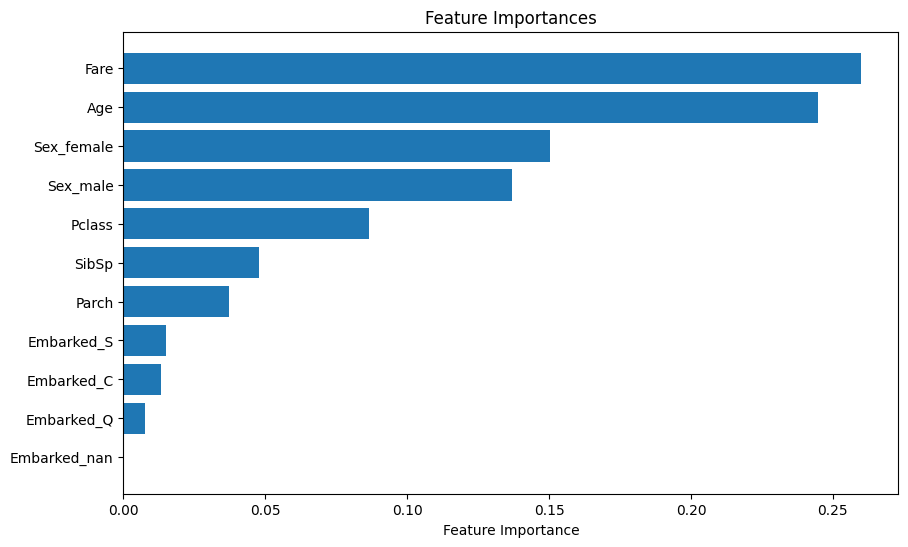

In [ ]:
# Optional: Feature importance visualization
importances = clf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Step 8: Hyperparameter Tuning with Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
# Re-train the model with the best hyperparameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50,
                       random_state=42)

In [ ]:
# Step 9: Cross-Validation
cv_scores = cross_val_score(best_clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")

Cross-Validation Scores: [0.81564246 0.79775281 0.84269663 0.80337079 0.85393258]
Mean Cross-Validation Score: 0.8226790534178645


In [ ]:
# Step 10: Additional Metrics
y_pred_val = best_clf.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred_val))

roc_auc = roc_auc_score(y_val, best_clf.predict_proba(X_val)[:, 1])
print(f"ROC AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       105
           1       0.83      0.74      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC AUC Score: 0.8940797940797941


In [ ]:
# Step 11: Save the updated test predictions
test_predictions = best_clf.predict(test_df)
output = pd.DataFrame({'PassengerId': pd.read_csv(test_path)['PassengerId'], 'Survived': test_predictions})
output.to_csv('/content/updated_test_predictions.csv', index=False)
print("Updated test predictions saved to /content/updated_test_predictions.csv")

Updated test predictions saved to /content/updated_test_predictions.csv
